In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 829)
(466039, 1)
validation
(80707, 829)
(80707, 1)
test
(46831, 829)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:14 - loss: 0.1022 - STD: 1.1975e-04 - MAE: 0.3052

 4/47 [=>............................] - ETA: 1s - loss: 0.0440 - STD: 4.1620e-04 - MAE: 0.1591  

 5/47 [==>...........................] - ETA: 1s - loss: 0.0424 - STD: 3.8394e-04 - MAE: 0.1553

 6/47 [==>...........................] - ETA: 1s - loss: 0.0419 - STD: 3.5092e-04 - MAE: 0.1542

 7/47 [===>..........................] - ETA: 1s - loss: 0.0415 - STD: 3.2240e-04 - MAE: 0.1533

 8/47 [====>.........................] - ETA: 1s - loss: 0.0407 - STD: 2.9954e-04 - MAE: 0.1511

 9/47 [====>.........................] - ETA: 1s - loss: 0.0395 - STD: 2.8280e-04 - MAE: 0.1474

10/47 [=====>........................] - ETA: 1s - loss: 0.0381 - STD: 2.7149e-04 - MAE: 0.1426

11/47 [======>.......................] - ETA: 1s - loss: 0.0366 - STD: 2.6453e-04 - MAE: 0.1372

12/47 [======>.......................] - ETA: 1s - loss: 0.0351 - STD: 2.6045e-04 - MAE: 0.1323

13/47 [=======>......................] - ETA: 1s - loss: 0.0338 - STD: 2.5798e-04 - MAE: 0.1287

14/47 [=======>......................] - ETA: 1s - loss: 0.0326 - STD: 2.5620e-04 - MAE: 0.1267

15/47 [========>.....................] - ETA: 1s - loss: 0.0317 - STD: 2.5434e-04 - MAE: 0.1261

16/47 [=========>....................] - ETA: 1s - loss: 0.0311 - STD: 2.5255e-04 - MAE: 0.1262

17/47 [=========>....................] - ETA: 1s - loss: 0.0306 - STD: 2.5079e-04 - MAE: 0.1267

18/47 [==========>...................] - ETA: 1s - loss: 0.0301 - STD: 2.4902e-04 - MAE: 0.1268

19/47 [===========>..................] - ETA: 1s - loss: 0.0296 - STD: 2.4737e-04 - MAE: 0.1266

20/47 [===========>..................] - ETA: 1s - loss: 0.0291 - STD: 2.4592e-04 - MAE: 0.1258

21/47 [============>.................] - ETA: 1s - loss: 0.0285 - STD: 2.4458e-04 - MAE: 0.1245

22/47 [=============>................] - ETA: 1s - loss: 0.0280 - STD: 2.4331e-04 - MAE: 0.1229

23/47 [=============>................] - ETA: 1s - loss: 0.0275 - STD: 2.4219e-04 - MAE: 0.1211

24/47 [==============>...............] - ETA: 1s - loss: 0.0271 - STD: 2.4109e-04 - MAE: 0.1193

25/47 [==============>...............] - ETA: 1s - loss: 0.0267 - STD: 2.4014e-04 - MAE: 0.1176

26/47 [===============>..............] - ETA: 1s - loss: 0.0264 - STD: 2.3939e-04 - MAE: 0.1160

27/47 [================>.............] - ETA: 1s - loss: 0.0262 - STD: 2.3879e-04 - MAE: 0.1145

28/47 [================>.............] - ETA: 1s - loss: 0.0259 - STD: 2.3844e-04 - MAE: 0.1131

29/47 [=================>............] - ETA: 1s - loss: 0.0256 - STD: 2.3828e-04 - MAE: 0.1119

30/47 [==================>...........] - ETA: 1s - loss: 0.0254 - STD: 2.3850e-04 - MAE: 0.1107

31/47 [==================>...........] - ETA: 0s - loss: 0.0251 - STD: 2.3903e-04 - MAE: 0.1096

32/47 [===================>..........] - ETA: 1s - loss: 0.0250 - STD: 2.3991e-04 - MAE: 0.1087

35/47 [=====================>........] - ETA: 0s - loss: 0.0243 - STD: 2.4416e-04 - MAE: 0.1071

37/47 [======================>.......] - ETA: 0s - loss: 0.0240 - STD: 2.4827e-04 - MAE: 0.1067

38/47 [=======================>......] - ETA: 0s - loss: 0.0238 - STD: 2.5056e-04 - MAE: 0.1065

39/47 [=======================>......] - ETA: 0s - loss: 0.0236 - STD: 2.5303e-04 - MAE: 0.1064

40/47 [========================>.....] - ETA: 0s - loss: 0.0235 - STD: 2.5559e-04 - MAE: 0.1062

41/47 [=========================>....] - ETA: 0s - loss: 0.0233 - STD: 2.5832e-04 - MAE: 0.1059

42/47 [=========================>....] - ETA: 0s - loss: 0.0232 - STD: 2.6097e-04 - MAE: 0.1056

43/47 [==========================>...] - ETA: 0s - loss: 0.0230 - STD: 2.6389e-04 - MAE: 0.1052

44/47 [===========================>..] - ETA: 0s - loss: 0.0229 - STD: 2.6677e-04 - MAE: 0.1047

45/47 [===========================>..] - ETA: 0s - loss: 0.0227 - STD: 2.6983e-04 - MAE: 0.1042

46/47 [============================>.] - ETA: 0s - loss: 0.0226 - STD: 2.7293e-04 - MAE: 0.1037

47/47 [==============================] - ETA: 0s - loss: 0.0225 - STD: 2.7620e-04 - MAE: 0.1032

47/47 [==============================] - 6s 89ms/step - loss: 0.0225 - STD: 2.7620e-04 - MAE: 0.1032 - val_loss: 0.0162 - val_STD: 3.2898e-04 - val_MAE: 0.0686


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0171 - STD: 4.4050e-04 - MAE: 0.0796

 2/47 [>.............................] - ETA: 3s - loss: 0.0175 - STD: 4.5167e-04 - MAE: 0.0805

 3/47 [>.............................] - ETA: 2s - loss: 0.0175 - STD: 4.6264e-04 - MAE: 0.0809

 4/47 [=>............................] - ETA: 2s - loss: 0.0173 - STD: 4.7316e-04 - MAE: 0.0810

 5/47 [==>...........................] - ETA: 2s - loss: 0.0171 - STD: 4.8400e-04 - MAE: 0.0813

 6/47 [==>...........................] - ETA: 2s - loss: 0.0171 - STD: 4.9702e-04 - MAE: 0.0823

 7/47 [===>..........................] - ETA: 2s - loss: 0.0171 - STD: 5.0874e-04 - MAE: 0.0830

 8/47 [====>.........................] - ETA: 2s - loss: 0.0171 - STD: 5.2259e-04 - MAE: 0.0839

 9/47 [====>.........................] - ETA: 2s - loss: 0.0171 - STD: 5.3655e-04 - MAE: 0.0848

10/47 [=====>........................] - ETA: 2s - loss: 0.0171 - STD: 5.5039e-04 - MAE: 0.0855

11/47 [======>.......................] - ETA: 2s - loss: 0.0171 - STD: 5.6442e-04 - MAE: 0.0861

12/47 [======>.......................] - ETA: 2s - loss: 0.0171 - STD: 5.7899e-04 - MAE: 0.0867

13/47 [=======>......................] - ETA: 2s - loss: 0.0171 - STD: 5.9348e-04 - MAE: 0.0870

15/47 [========>.....................] - ETA: 1s - loss: 0.0171 - STD: 6.2357e-04 - MAE: 0.0874

16/47 [=========>....................] - ETA: 1s - loss: 0.0171 - STD: 6.3908e-04 - MAE: 0.0873

17/47 [=========>....................] - ETA: 1s - loss: 0.0170 - STD: 6.5504e-04 - MAE: 0.0871

19/47 [===========>..................] - ETA: 1s - loss: 0.0170 - STD: 6.8925e-04 - MAE: 0.0868

20/47 [===========>..................] - ETA: 1s - loss: 0.0170 - STD: 7.0727e-04 - MAE: 0.0867

21/47 [============>.................] - ETA: 1s - loss: 0.0170 - STD: 7.2669e-04 - MAE: 0.0866

23/47 [=============>................] - ETA: 1s - loss: 0.0170 - STD: 7.6851e-04 - MAE: 0.0864

24/47 [==============>...............] - ETA: 1s - loss: 0.0170 - STD: 7.9115e-04 - MAE: 0.0863

25/47 [==============>...............] - ETA: 1s - loss: 0.0170 - STD: 8.1556e-04 - MAE: 0.0863

26/47 [===============>..............] - ETA: 1s - loss: 0.0170 - STD: 8.4145e-04 - MAE: 0.0864

27/47 [================>.............] - ETA: 1s - loss: 0.0170 - STD: 8.6876e-04 - MAE: 0.0864

28/47 [================>.............] - ETA: 1s - loss: 0.0170 - STD: 8.9748e-04 - MAE: 0.0865

29/47 [=================>............] - ETA: 0s - loss: 0.0169 - STD: 9.2736e-04 - MAE: 0.0865

31/47 [==================>...........] - ETA: 0s - loss: 0.0169 - STD: 9.9171e-04 - MAE: 0.0866

33/47 [====================>.........] - ETA: 0s - loss: 0.0169 - STD: 0.0011 - MAE: 0.0866    

34/47 [====================>.........] - ETA: 0s - loss: 0.0169 - STD: 0.0011 - MAE: 0.0866

35/47 [=====================>........] - ETA: 0s - loss: 0.0169 - STD: 0.0011 - MAE: 0.0865

36/47 [=====================>........] - ETA: 0s - loss: 0.0169 - STD: 0.0012 - MAE: 0.0864

37/47 [======================>.......] - ETA: 0s - loss: 0.0169 - STD: 0.0012 - MAE: 0.0863

38/47 [=======================>......] - ETA: 0s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0863

39/47 [=======================>......] - ETA: 0s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0863

41/47 [=========================>....] - ETA: 0s - loss: 0.0168 - STD: 0.0015 - MAE: 0.0862

42/47 [=========================>....] - ETA: 0s - loss: 0.0168 - STD: 0.0015 - MAE: 0.0862

43/47 [==========================>...] - ETA: 0s - loss: 0.0168 - STD: 0.0016 - MAE: 0.0862

44/47 [===========================>..] - ETA: 0s - loss: 0.0168 - STD: 0.0017 - MAE: 0.0863

45/47 [===========================>..] - ETA: 0s - loss: 0.0168 - STD: 0.0017 - MAE: 0.0863

46/47 [============================>.] - ETA: 0s - loss: 0.0168 - STD: 0.0018 - MAE: 0.0863

47/47 [==============================] - ETA: 0s - loss: 0.0168 - STD: 0.0019 - MAE: 0.0863

47/47 [==============================] - 3s 58ms/step - loss: 0.0168 - STD: 0.0019 - MAE: 0.0863 - val_loss: 0.0148 - val_STD: 0.0051 - val_MAE: 0.0719


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0160 - STD: 0.0068 - MAE: 0.0855

 2/47 [>.............................] - ETA: 2s - loss: 0.0154 - STD: 0.0071 - MAE: 0.0837

 3/47 [>.............................] - ETA: 2s - loss: 0.0157 - STD: 0.0074 - MAE: 0.0840

 4/47 [=>............................] - ETA: 2s - loss: 0.0157 - STD: 0.0077 - MAE: 0.0838

 5/47 [==>...........................] - ETA: 2s - loss: 0.0156 - STD: 0.0081 - MAE: 0.0831

 6/47 [==>...........................] - ETA: 2s - loss: 0.0155 - STD: 0.0085 - MAE: 0.0829

 7/47 [===>..........................] - ETA: 2s - loss: 0.0155 - STD: 0.0089 - MAE: 0.0828

 8/47 [====>.........................] - ETA: 2s - loss: 0.0155 - STD: 0.0094 - MAE: 0.0827

10/47 [=====>........................] - ETA: 1s - loss: 0.0153 - STD: 0.0104 - MAE: 0.0823

11/47 [======>.......................] - ETA: 1s - loss: 0.0153 - STD: 0.0110 - MAE: 0.0822

12/47 [======>.......................] - ETA: 1s - loss: 0.0151 - STD: 0.0116 - MAE: 0.0820

13/47 [=======>......................] - ETA: 1s - loss: 0.0150 - STD: 0.0122 - MAE: 0.0817

14/47 [=======>......................] - ETA: 1s - loss: 0.0149 - STD: 0.0129 - MAE: 0.0814

15/47 [========>.....................] - ETA: 1s - loss: 0.0148 - STD: 0.0137 - MAE: 0.0811

16/47 [=========>....................] - ETA: 1s - loss: 0.0147 - STD: 0.0144 - MAE: 0.0807

17/47 [=========>....................] - ETA: 1s - loss: 0.0146 - STD: 0.0153 - MAE: 0.0804

18/47 [==========>...................] - ETA: 1s - loss: 0.0145 - STD: 0.0162 - MAE: 0.0800

19/47 [===========>..................] - ETA: 1s - loss: 0.0144 - STD: 0.0171 - MAE: 0.0796

20/47 [===========>..................] - ETA: 1s - loss: 0.0142 - STD: 0.0182 - MAE: 0.0793

21/47 [============>.................] - ETA: 1s - loss: 0.0141 - STD: 0.0193 - MAE: 0.0789

22/47 [=============>................] - ETA: 1s - loss: 0.0140 - STD: 0.0205 - MAE: 0.0785

24/47 [==============>...............] - ETA: 1s - loss: 0.0137 - STD: 0.0229 - MAE: 0.0775

25/47 [==============>...............] - ETA: 1s - loss: 0.0135 - STD: 0.0242 - MAE: 0.0770

26/47 [===============>..............] - ETA: 1s - loss: 0.0134 - STD: 0.0255 - MAE: 0.0764

27/47 [================>.............] - ETA: 1s - loss: 0.0132 - STD: 0.0269 - MAE: 0.0759

28/47 [================>.............] - ETA: 0s - loss: 0.0130 - STD: 0.0283 - MAE: 0.0753

29/47 [=================>............] - ETA: 0s - loss: 0.0128 - STD: 0.0298 - MAE: 0.0748

30/47 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 0.0314 - MAE: 0.0743

31/47 [==================>...........] - ETA: 0s - loss: 0.0125 - STD: 0.0329 - MAE: 0.0738

32/47 [===================>..........] - ETA: 0s - loss: 0.0123 - STD: 0.0344 - MAE: 0.0733

33/47 [====================>.........] - ETA: 0s - loss: 0.0122 - STD: 0.0359 - MAE: 0.0727

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 0.0373 - MAE: 0.0722

35/47 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 0.0389 - MAE: 0.0717

36/47 [=====================>........] - ETA: 0s - loss: 0.0117 - STD: 0.0404 - MAE: 0.0712

37/47 [======================>.......] - ETA: 0s - loss: 0.0116 - STD: 0.0420 - MAE: 0.0707

38/47 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.0434 - MAE: 0.0703

40/47 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0460 - MAE: 0.0694

41/47 [=========================>....] - ETA: 0s - loss: 0.0111 - STD: 0.0473 - MAE: 0.0690

42/47 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0487 - MAE: 0.0686

44/47 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0511 - MAE: 0.0678

45/47 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 0.0522 - MAE: 0.0674

46/47 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 0.0533 - MAE: 0.0670

47/47 [==============================] - ETA: 0s - loss: 0.0104 - STD: 0.0544 - MAE: 0.0666

47/47 [==============================] - 3s 56ms/step - loss: 0.0104 - STD: 0.0544 - MAE: 0.0666 - val_loss: 0.0046 - val_STD: 0.0745 - val_MAE: 0.0451


Epoch 4/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.1079 - MAE: 0.0486

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.1059 - MAE: 0.0482

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.1041 - MAE: 0.0481

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.1049 - MAE: 0.0481

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.1061 - MAE: 0.0480

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.1065 - MAE: 0.0476

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.1064 - MAE: 0.0476

 9/47 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.1067 - MAE: 0.0474

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.1071 - MAE: 0.0472

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.1071 - MAE: 0.0471

12/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.1072 - MAE: 0.0469

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.1074 - MAE: 0.0468

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.1076 - MAE: 0.0466

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.1076 - MAE: 0.0465

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.1079 - MAE: 0.0463

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.1081 - MAE: 0.0461

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.1082 - MAE: 0.0460

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.1085 - MAE: 0.0458

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.1092 - MAE: 0.0456

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.1093 - MAE: 0.0455

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.1094 - MAE: 0.0454

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.1097 - MAE: 0.0453

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.1099 - MAE: 0.0453

28/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.1100 - MAE: 0.0452

29/47 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.1101 - MAE: 0.0451

30/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.1104 - MAE: 0.0450

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.1108 - MAE: 0.0449

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.1107 - MAE: 0.0448

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.1108 - MAE: 0.0447

36/47 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.1112 - MAE: 0.0446

37/47 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.1111 - MAE: 0.0445

38/47 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.1111 - MAE: 0.0444

39/47 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.1113 - MAE: 0.0444

40/47 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.1114 - MAE: 0.0443

41/47 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.1114 - MAE: 0.0442

42/47 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.1114 - MAE: 0.0442

44/47 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.1116 - MAE: 0.0441

46/47 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.1119 - MAE: 0.0440

47/47 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.1119 - MAE: 0.0439

47/47 [==============================] - 3s 55ms/step - loss: 0.0042 - STD: 0.1119 - MAE: 0.0439 - val_loss: 0.0039 - val_STD: 0.0966 - val_MAE: 0.0399


Epoch 5/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.1183 - MAE: 0.0415

 3/47 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.1163 - MAE: 0.0411

 4/47 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.1148 - MAE: 0.0410

 5/47 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.1159 - MAE: 0.0411

 6/47 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.1161 - MAE: 0.0411

 7/47 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.1154 - MAE: 0.0410

 8/47 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.1152 - MAE: 0.0410

 9/47 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.1153 - MAE: 0.0410

10/47 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.1155 - MAE: 0.0410

11/47 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1156 - MAE: 0.0409

12/47 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1155 - MAE: 0.0408

13/47 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.1153 - MAE: 0.0407

14/47 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.1155 - MAE: 0.0407

15/47 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.1155 - MAE: 0.0406

16/47 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.1156 - MAE: 0.0406

17/47 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.1156 - MAE: 0.0405

18/47 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.1156 - MAE: 0.0404

19/47 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.1156 - MAE: 0.0404

20/47 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0404

21/47 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0404

22/47 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0403

23/47 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0403

24/47 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0403

25/47 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0402

26/47 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1155 - MAE: 0.0402

27/47 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1155 - MAE: 0.0401

28/47 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.1156 - MAE: 0.0401

29/47 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0401

30/47 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0401

31/47 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0401

32/47 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0400

33/47 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0400

34/47 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0400

35/47 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1157 - MAE: 0.0399

36/47 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0399

37/47 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1158 - MAE: 0.0399

38/47 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1157 - MAE: 0.0398

39/47 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1158 - MAE: 0.0398

40/47 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1158 - MAE: 0.0398

41/47 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1158 - MAE: 0.0398

43/47 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1160 - MAE: 0.0397

44/47 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1160 - MAE: 0.0397

45/47 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1160 - MAE: 0.0397

46/47 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1162 - MAE: 0.0397

47/47 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1163 - MAE: 0.0396

47/47 [==============================] - 3s 55ms/step - loss: 0.0033 - STD: 0.1163 - MAE: 0.0396 - val_loss: 0.0035 - val_STD: 0.0958 - val_MAE: 0.0381


Epoch 6/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1137 - MAE: 0.0389

 2/47 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1173 - MAE: 0.0393

 3/47 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1175 - MAE: 0.0388

 4/47 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.1162 - MAE: 0.0386

 5/47 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.1163 - MAE: 0.0384

 6/47 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.1167 - MAE: 0.0383

 7/47 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.1167 - MAE: 0.0383

 8/47 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.1167 - MAE: 0.0384

 9/47 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0384

10/47 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0384

11/47 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1166 - MAE: 0.0384

12/47 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1168 - MAE: 0.0384

13/47 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0384

14/47 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

15/47 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

16/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1174 - MAE: 0.0383

17/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1174 - MAE: 0.0382

18/47 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0382

19/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0381

20/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0382

21/47 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1169 - MAE: 0.0382

22/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1170 - MAE: 0.0382

23/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0382

24/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1170 - MAE: 0.0382

25/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0381

26/47 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0382

27/47 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0382

28/47 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0381

29/47 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0382

30/47 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0381

31/47 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1171 - MAE: 0.0381

32/47 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0381

33/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0381

34/47 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1173 - MAE: 0.0381

35/47 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1174 - MAE: 0.0381

36/47 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0381

38/47 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0380

39/47 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0380

40/47 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1174 - MAE: 0.0380

41/47 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0380

42/47 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0380

43/47 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1174 - MAE: 0.0379

44/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0379

45/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0379

46/47 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0379

47/47 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1176 - MAE: 0.0379

47/47 [==============================] - 3s 56ms/step - loss: 0.0030 - STD: 0.1176 - MAE: 0.0379 - val_loss: 0.0033 - val_STD: 0.1013 - val_MAE: 0.0351


Epoch 7/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1218 - MAE: 0.0384

 3/47 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1169 - MAE: 0.0374

 4/47 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1171 - MAE: 0.0373

 5/47 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0374

 6/47 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1175 - MAE: 0.0375

 7/47 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1177 - MAE: 0.0374

 8/47 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0375

 9/47 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1177 - MAE: 0.0375

10/47 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1178 - MAE: 0.0375

11/47 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0375

12/47 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0375

13/47 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0375

14/47 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0375

15/47 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0374

16/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0373

17/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0373

18/47 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0373

19/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1179 - MAE: 0.0373

20/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1180 - MAE: 0.0372

21/47 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0373

22/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0373

23/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0372

24/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0372

25/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0372

26/47 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0372

27/47 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0372

28/47 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0372

29/47 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0371

30/47 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0371

31/47 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0371

32/47 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0371

33/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0371

34/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0371

35/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0371

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

37/47 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0370

38/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

40/47 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

41/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0370

42/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0370

43/47 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0370

44/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

45/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0369

46/47 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0370

47/47 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370

47/47 [==============================] - 3s 56ms/step - loss: 0.0029 - STD: 0.1183 - MAE: 0.0370 - val_loss: 0.0032 - val_STD: 0.0967 - val_MAE: 0.0365


Epoch 8/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0356

 2/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0369

 3/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1204 - MAE: 0.0367

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1188 - MAE: 0.0367

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1197 - MAE: 0.0368

 6/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1194 - MAE: 0.0366

 7/47 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0367

 9/47 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1189 - MAE: 0.0367

10/47 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1188 - MAE: 0.0368

12/47 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0367

13/47 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0366

15/47 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1194 - MAE: 0.0365

16/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0365

17/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0365

18/47 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0364

19/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0364

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0363

21/47 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1188 - MAE: 0.0363

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0363

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1187 - MAE: 0.0363

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0363

28/47 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0363

29/47 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0363

30/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1187 - MAE: 0.0363

31/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0362

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0363

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0362

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0362

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0362

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0362

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0362

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0361

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0361

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0361

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0361

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0361

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0361

47/47 [==============================] - 3s 56ms/step - loss: 0.0027 - STD: 0.1191 - MAE: 0.0361 - val_loss: 0.0031 - val_STD: 0.0972 - val_MAE: 0.0357


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0350

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1170 - MAE: 0.0350

 3/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1181 - MAE: 0.0356

 4/47 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0358

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0356

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0356

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0356

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0356

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0356

10/47 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1188 - MAE: 0.0357

11/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0357

12/47 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0357

13/47 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0357

14/47 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0357

15/47 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0357

16/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1187 - MAE: 0.0357

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0357

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0357

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0356

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0356

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0356

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0356

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0356

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0356

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0356

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0357

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0357

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357

29/47 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357

30/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0357

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0358

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0358

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0358

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0358

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0358

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0357

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

47/47 [==============================] - 3s 57ms/step - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357 - val_loss: 0.0030 - val_STD: 0.0988 - val_MAE: 0.0347


Epoch 10/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0353

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0353

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1195 - MAE: 0.0353

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1195 - MAE: 0.0352

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

10/47 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

11/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

12/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

13/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0352

14/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

15/47 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0351

16/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0351

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0352

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0354

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0354

28/47 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

29/47 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0354

30/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

31/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0354

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0353

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0353

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0353

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0353

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0353

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0353

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0353

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0352

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352

47/47 [==============================] - 3s 56ms/step - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352 - val_loss: 0.0030 - val_STD: 0.0971 - val_MAE: 0.0348


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0347

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1189 - MAE: 0.0349

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1193 - MAE: 0.0351

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0353

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1207 - MAE: 0.0352

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0354

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1209 - MAE: 0.0353

13/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0356

15/47 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0355

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0356

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0356

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0357

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0357

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0357

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0358

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0358

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1204 - MAE: 0.0358

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0359

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0358

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1203 - MAE: 0.0359

29/47 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0358

30/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0358

31/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0358

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0358

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0358

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0359

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0358

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0358

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0358

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0358

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0358

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0357

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0357

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0357

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0357

47/47 [==============================] - 3s 56ms/step - loss: 0.0026 - STD: 0.1199 - MAE: 0.0357 - val_loss: 0.0031 - val_STD: 0.0960 - val_MAE: 0.0369


Epoch 12/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0351

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0351

 3/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0357

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0354

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0354

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0354

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0352

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1188 - MAE: 0.0352

10/47 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0352

11/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0351

12/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0350

13/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1188 - MAE: 0.0350

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0350

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0350

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0350

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0349

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1192 - MAE: 0.0348

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0348

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1191 - MAE: 0.0348

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1192 - MAE: 0.0348

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0348

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0348

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1194 - MAE: 0.0348

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0348

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0348

28/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1195 - MAE: 0.0348

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0348

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0348

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0348

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0348

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0348

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0348

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0349

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0349

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0349

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0349

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0348

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0348

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0348

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

47/47 [==============================] - 3s 58ms/step - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348 - val_loss: 0.0029 - val_STD: 0.0998 - val_MAE: 0.0341


Epoch 13/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0340

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0345

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0347

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0346

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0346

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0346

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0346

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0347

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0347

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0347

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

12/47 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

13/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0344

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

47/47 [==============================] - 3s 60ms/step - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346 - val_loss: 0.0029 - val_STD: 0.0979 - val_MAE: 0.0345


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0341

 2/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1192 - MAE: 0.0339

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0344

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0343

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0344

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0344

10/47 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

11/47 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

12/47 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0345

13/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0344

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0344

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0343

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

28/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0343

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0343

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

47/47 [==============================] - 3s 58ms/step - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344 - val_loss: 0.0029 - val_STD: 0.0998 - val_MAE: 0.0334


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0344

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0348

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0350

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0349

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0347

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0349

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0351

 9/47 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1210 - MAE: 0.0352

10/47 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1212 - MAE: 0.0351

11/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0352

12/47 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1210 - MAE: 0.0353

13/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1207 - MAE: 0.0352

14/47 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0351

15/47 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0351

16/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1207 - MAE: 0.0351

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0350

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0350

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0349

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0349

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0348

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0348

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0348

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0347

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0347

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0346

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0345

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0345

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0345

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

47/47 [==============================] - 3s 62ms/step - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344 - val_loss: 0.0029 - val_STD: 0.1021 - val_MAE: 0.0334


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0352

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0351

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0348

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1212 - MAE: 0.0346

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0348

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0350

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0350

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0349

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0348

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0348

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0348

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0347

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0346

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0346

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0346

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0347

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0346

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0343

47/47 [==============================] - 3s 63ms/step - loss: 0.0025 - STD: 0.1207 - MAE: 0.0343 - val_loss: 0.0029 - val_STD: 0.0991 - val_MAE: 0.0334


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1196 - MAE: 0.0345

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1187 - MAE: 0.0343

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0343

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0342

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

47/47 [==============================] - 3s 65ms/step - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341 - val_loss: 0.0029 - val_STD: 0.1004 - val_MAE: 0.0333


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1234 - MAE: 0.0342

 2/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0344

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0343

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0349

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1210 - MAE: 0.0352

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0350

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0349

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0349

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0350

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0349

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1210 - MAE: 0.0349

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0350

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0351

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0350

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1210 - MAE: 0.0350

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1212 - MAE: 0.0351

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0350

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0349

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0350

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0349

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0349

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0348

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0348

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0348

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0347

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0347

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0346

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0346

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0344

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0343

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

47/47 [==============================] - 3s 63ms/step - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343 - val_loss: 0.0029 - val_STD: 0.1008 - val_MAE: 0.0335


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

 2/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0338

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0338

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1219 - MAE: 0.0338

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0338

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

14/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0342

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

47/47 [==============================] - 3s 63ms/step - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341 - val_loss: 0.0029 - val_STD: 0.0994 - val_MAE: 0.0342


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0337

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0333

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1223 - MAE: 0.0335

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1227 - MAE: 0.0337

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0337

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1221 - MAE: 0.0338

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0337

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0336

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0337

13/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

14/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0338

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0338

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0339

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0339

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0339

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0339

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0338

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0338

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0338

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0338

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

47/47 [==============================] - 3s 59ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337 - val_loss: 0.0029 - val_STD: 0.0994 - val_MAE: 0.0343


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0340

 2/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1198 - MAE: 0.0338

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1199 - MAE: 0.0340

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0340

 8/47 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0340

 9/47 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0340

11/47 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0339

12/47 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0339

13/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

14/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0337

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0338

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0337

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0337

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

47/47 [==============================] - 3s 56ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343 - val_loss: 0.0029 - val_STD: 0.1007 - val_MAE: 0.0331


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1229 - MAE: 0.0348

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0358

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1208 - MAE: 0.0353

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0350

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0349

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0347

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0346

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0345

10/47 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0344

11/47 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

12/47 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0342

13/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0341

14/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1199 - MAE: 0.0341

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0341

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1201 - MAE: 0.0340

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0340

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0340

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0339

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0339

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

47/47 [==============================] - 3s 55ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337 - val_loss: 0.0030 - val_STD: 0.0971 - val_MAE: 0.0358


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1188 - MAE: 0.0333

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1199 - MAE: 0.0335

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1199 - MAE: 0.0336

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0334

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0334

 8/47 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

 9/47 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0334

10/47 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0335

11/47 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

12/47 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

13/47 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

14/47 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0334

15/47 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335

18/47 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0336

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0337

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0337

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0337

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0338

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

47/47 [==============================] - 3s 56ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338 - val_loss: 0.0029 - val_STD: 0.1007 - val_MAE: 0.0335


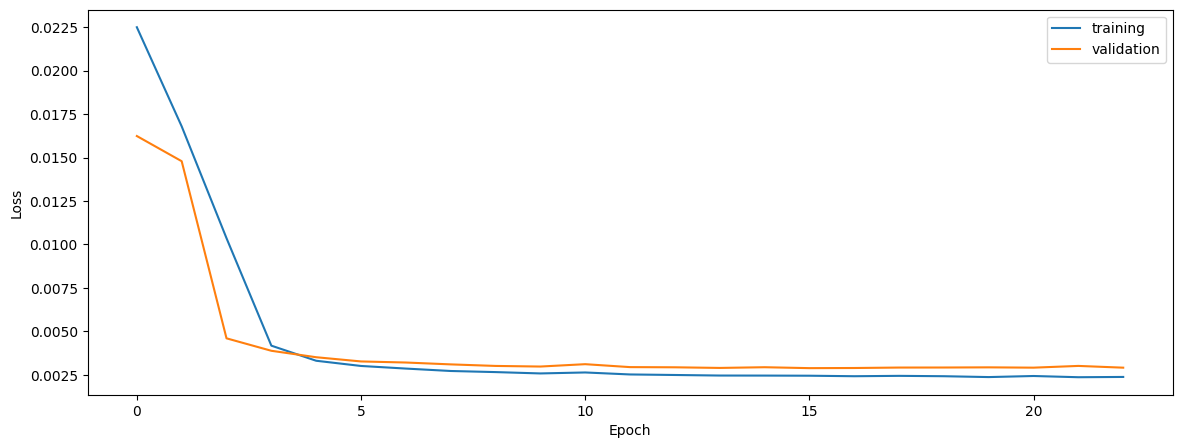

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9272853214874268
0.9048527105629551
0.9328779994982561


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9272853214874268
0.9048527105629551
0.9328779994982561


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9313942921495685
0.9185425444809735
0.9314830460117105


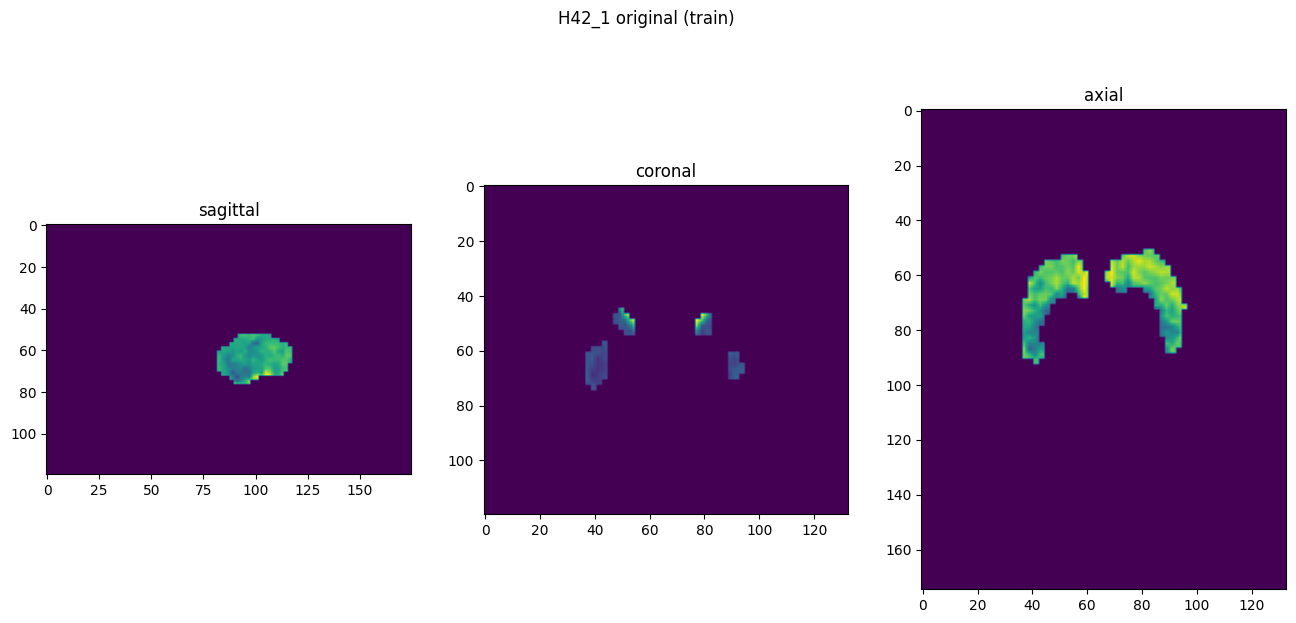

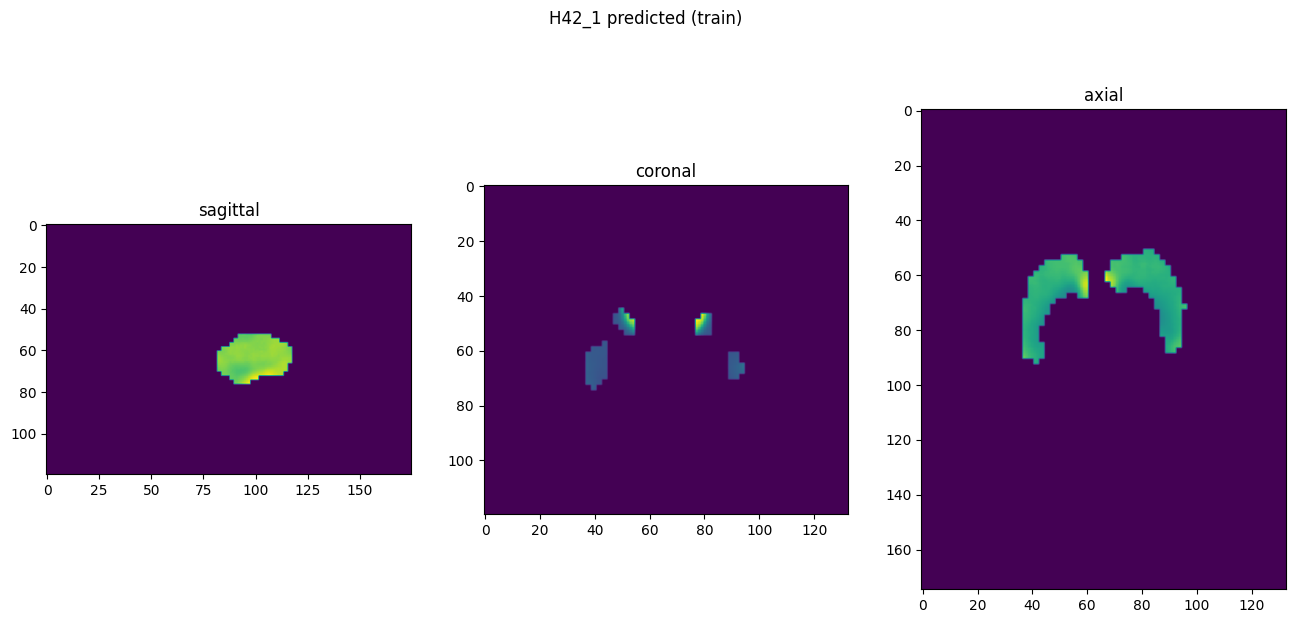

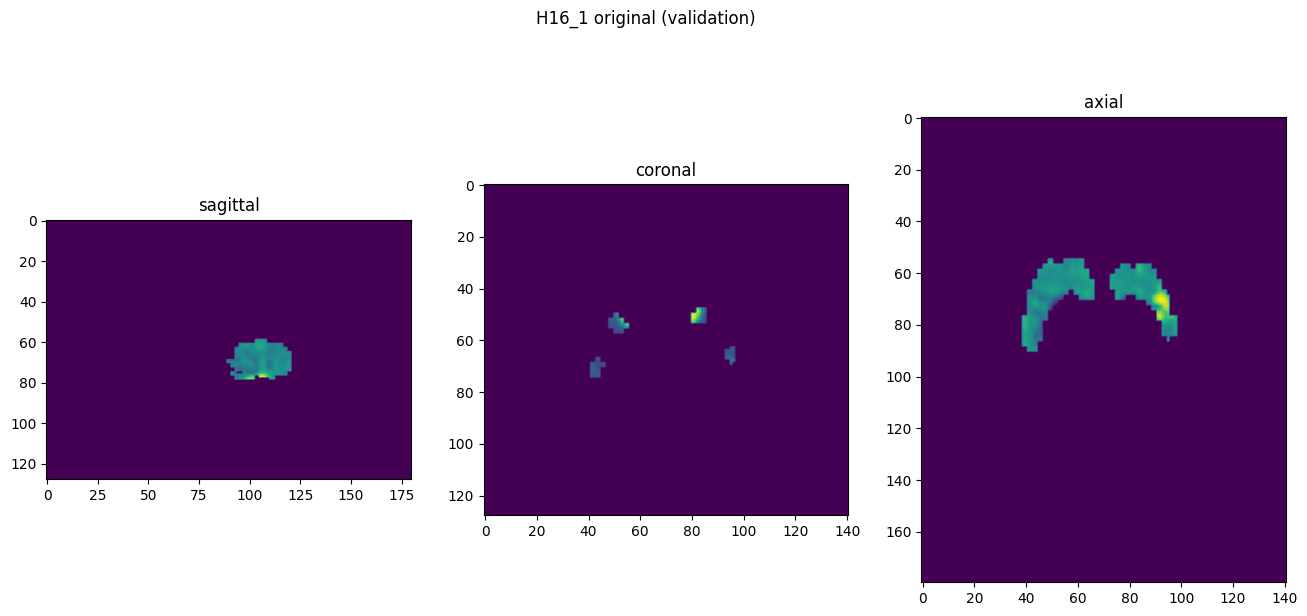

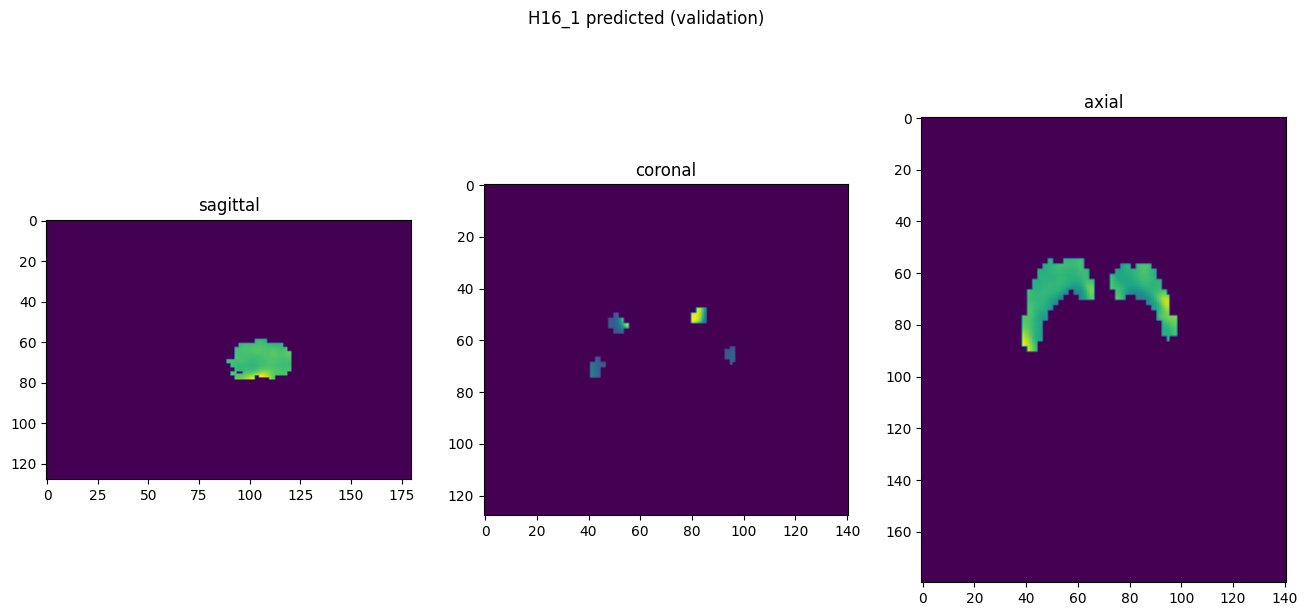

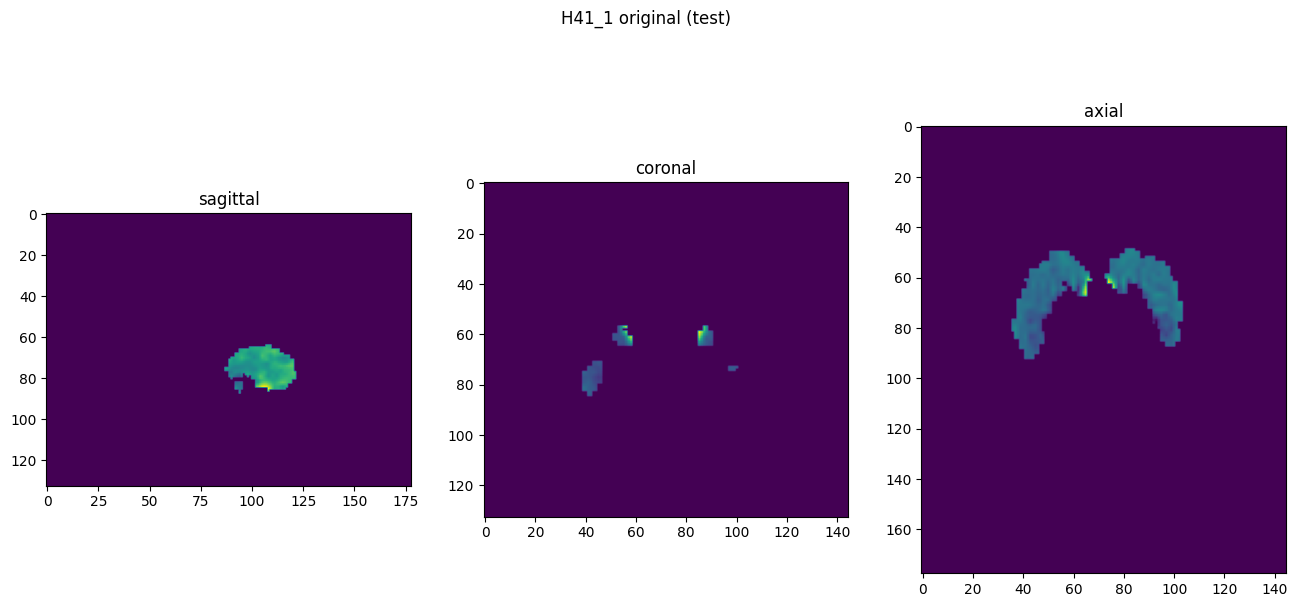

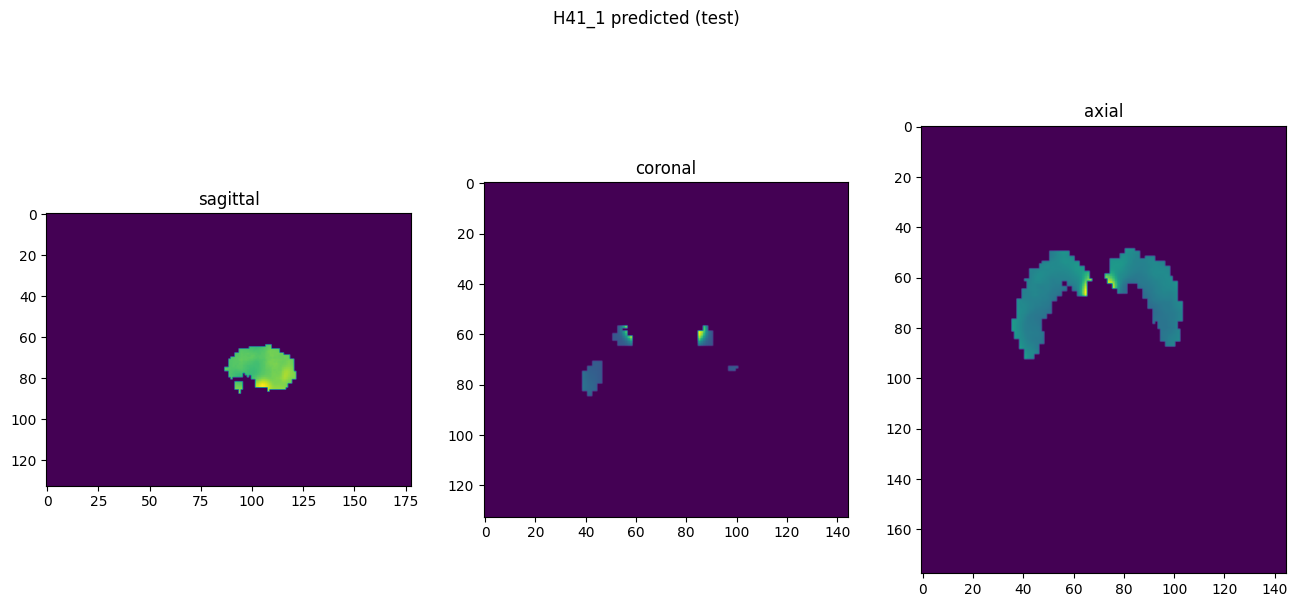

In [10]:
showResults(model, gen, threshold=None, background=False)